# <center> </center>
# <center> **Computer Vision** </center>
# <center> **Portfolio Exam 3**</center>
# <center>**Implement and analyze a Variational Autoencoder on CelebA**</center>

**Latent Dim = 128**
**Beta = 10**

**Submitted by:**
****

*   **Riya Biju - 10000742**
*   **Harsha Sathish - 10001000**
*   **Harshith Babu Prakash Babu - 10001191**


In [ ]:
"""
VAE Implementation for CelebA Dataset - Portfolio 3 Phase 1
Baseline model with latent_dim = 128
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ============================================================================
# Dataset Class
# ============================================================================

class CelebADataset(Dataset):
    """
    Custom Dataset for CelebA aligned and cropped images
    """
    def __init__(self, root_dir, partition_file, split='train', transform=None, subset_size=None):
        """
        Args:
            root_dir: Path to CelebA directory
            partition_file: Path to list_eval_partition.txt
            split: 'train', 'val', or 'test' (0, 1, 2 in partition file)
            transform: Transformations to apply
            subset_size: If specified, use only this many images (for faster training)
        """
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'Img', 'img_align_celeba')
        self.transform = transform
        
        # Load partition information
        self.image_files = []
        split_map = {'train': 0, 'val': 1, 'test': 2}
        split_id = split_map[split]
        
        with open(partition_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    img_name, partition = parts
                    if int(partition) == split_id:
                        self.image_files.append(img_name)
        
        # Apply subset if specified
        if subset_size is not None and subset_size < len(self.image_files):
            np.random.seed(42)
            indices = np.random.choice(len(self.image_files), subset_size, replace=False)
            self.image_files = [self.image_files[i] for i in sorted(indices)]
        
        print(f"{split.upper()} set: {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


# ============================================================================
# VAE Model Architecture
# ============================================================================

class VAE(nn.Module):
    """
    Convolutional Variational Autoencoder for CelebA (64x64 images)
    """
    def __init__(self, latent_dim=128, img_channels=3):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # ====== ENCODER ======
        # Input: (3, 64, 64)
        self.encoder = nn.Sequential(
            # Layer 1: (3, 64, 64) -> (32, 32, 32)
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: (32, 32, 32) -> (64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: (64, 16, 16) -> (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: (128, 8, 8) -> (256, 4, 4)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Flattened feature size: 256 * 4 * 4 = 4096
        self.fc_encoder = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True)
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # ====== DECODER ======
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256 * 4 * 4),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            # Layer 1: (256, 4, 4) -> (128, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Layer 2: (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Layer 3: (64, 16, 16) -> (32, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Layer 4: (32, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        h = self.fc_encoder(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decoder(z)
        h = h.view(h.size(0), 256, 4, 4)  # Reshape
        return self.decoder(h)
    
    def forward(self, x):
        """Full forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# ============================================================================
# Loss Function 
# ============================================================================
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE Loss - Production Ready Version
    """
    batch_size = x.size(0)
    
    # Reconstruction: Binary cross-entropy
    # Sum over pixels, mean over batch
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_size
    # Per-pixel for display
    recon_loss_display = recon_loss / (x.size(1) * x.size(2) * x.size(3))
    
    # KL Divergence
    # Sum over latent dims, mean over batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    
    # Total (both terms are now comparable in magnitude)
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss_display, kl_loss



# ============================================================================
# Training Function - WITH SAFETY CHECKS
# ============================================================================

def train_epoch(model, train_loader, optimizer, epoch, beta=1.0):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, data in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        if kl_loss.item() < 1.0 and epoch > 1:
            print(f"\n⚠️ WARNING: KL collapsed at epoch {epoch}, batch {batch_idx}")
            print(f"   KL: {kl_loss.item():.6f}")
            print(f"   mu range: [{mu.min():.4f}, {mu.max():.4f}]")
            print(f"   logvar range: [{logvar.min():.4f}, {logvar.max():.4f}]")
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}'
        })
    
    # Average losses
    n_batches = len(train_loader)
    return train_loss / n_batches, train_recon_loss / n_batches, train_kl_loss / n_batches


def validate(model, val_loader, beta=1.0):
    """Validate the model"""
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kl_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
    
    # Average losses
    n_batches = len(val_loader)
    return val_loss / n_batches, val_recon_loss / n_batches, val_kl_loss / n_batches


# ============================================================================
# Visualization Functions
# ============================================================================

def save_sample_images(model, val_loader, epoch, save_dir, num_samples=8):
    """Save sample reconstructions"""
    model.eval()
    
    # Get a batch
    data = next(iter(val_loader))[:num_samples].to(device)
    
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Move to CPU and denormalize
    data = data.cpu()
    recon = recon.cpu()
    
    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        # Original
        axes[0, i].imshow(data[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(recon[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'reconstruction_epoch_{epoch}.png'), dpi=100, bbox_inches='tight')
    plt.close()


def plot_training_curves(history, save_dir):
    """Plot and save training curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Total Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Total Loss')
    axes[0].set_title('Total Loss (ELBO)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[1].plot(epochs, history['train_recon'], label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_recon'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Reconstruction Loss')
    axes[1].set_title('Reconstruction Loss (BCE)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # KL Divergence
    axes[2].plot(epochs, history['train_kl'], label='Train', linewidth=2)
    axes[2].plot(epochs, history['val_kl'], label='Validation', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KL Divergence')
    axes[2].set_title('KL Divergence')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()


# ============================================================================
# Main Training Script
# ============================================================================

def main():
    # ========== Configuration ==========
    config = {
        'latent_dim': 128,
        'beta': 10.0, 
        'img_size': 64,
        'batch_size': 128,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'subset_train': 50000,  # Use 50k training images (adjust as needed)
        'subset_val': 5000,     # Use 5k validation images
        'num_workers': 0,       # DataLoader workers
        'save_interval': 5,     # Save checkpoint every N epochs
    }
    
    print("=" * 60)
    print("VAE Training Configuration")
    print("=" * 60)
    for key, value in config.items():
        print(f"{key:20s}: {value}")
    print("=" * 60)
    
    # ========== Paths ==========
    celeba_root = './CelebA'  # Adjust if needed
    partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')
    
    # Create output directories
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./outputs_beta_10/vae_baseline_latent{config["latent_dim"]}_{timestamp}'
    checkpoint_dir = os.path.join(output_dir, 'checkpoints')
    sample_dir = os.path.join(output_dir, 'samples')
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    # Save configuration
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    # ========== Data Transforms ==========
    transform = transforms.Compose([
        transforms.Resize(config['img_size']),
        transforms.CenterCrop(config['img_size']),
        transforms.ToTensor(),
        # Images are already in [0, 1] after ToTensor()
    ])
    
    # ========== Datasets and DataLoaders ==========
    print("\nLoading datasets...")
    train_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='train',
        transform=transform,
        subset_size=config['subset_train']
    )
    
    val_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='val',
        transform=transform,
        subset_size=config['subset_val']
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    # ========== Model Setup ==========
    print("\nInitializing model...")
    model = VAE(latent_dim=config['latent_dim']).to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # ========== Training Loop ==========
    print("\n" + "=" * 60)
    print("Starting Training")
    print("=" * 60)
    
    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'val_loss': [], 'val_recon': [], 'val_kl': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(1, config['num_epochs'] + 1):
        # Train
        train_loss, train_recon, train_kl = train_epoch(
            model, train_loader, optimizer, epoch, beta=config['beta']
        )
        
        # Validate
        val_loss, val_recon, val_kl = validate(model, val_loader, beta=config['beta'])
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_recon'].append(train_recon)
        history['train_kl'].append(train_kl)
        history['val_loss'].append(val_loss)
        history['val_recon'].append(val_recon)
        history['val_kl'].append(val_kl)
        
        # Print epoch summary
        print(f"\nEpoch {epoch}/{config['num_epochs']}:")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")
        
        # HEALTH CHECK
        if val_kl < 10.0:
            print(f"  ⚠️  WARNING: KL very low ({val_kl:.4f}) - monitor for collapse")
        elif val_kl > 200.0:
            print(f"  ⚠️  WARNING: KL very high ({val_kl:.4f}) - model may ignore inputs")
        
        # Save sample reconstructions
        if epoch % config['save_interval'] == 0:
            save_sample_images(model, val_loader, epoch, sample_dir)
        
        # Save checkpoint
        if epoch % config['save_interval'] == 0 or epoch == config['num_epochs']:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"  Saved checkpoint: {checkpoint_path}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
                'val_loss': val_loss,
            }
            best_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(best_checkpoint, best_path)
            print(f"  ⭐ New best model saved! Val Loss: {val_loss:.4f}")
    
    # ========== Final Steps ==========
    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    
    # Plot training curves
    plot_training_curves(history, output_dir)
    print(f"\nTraining curves saved to: {output_dir}/training_curves.png")
    
    # Save final model
    final_checkpoint = {
        'epoch': config['num_epochs'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': config,
        'history': history,
    }
    final_path = os.path.join(checkpoint_dir, 'final_model.pth')
    torch.save(final_checkpoint, final_path)
    print(f"Final model saved to: {final_path}")
    
    # Save training history
    with open(os.path.join(output_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=4)
    
    print(f"\nAll outputs saved to: {output_dir}")
    print(f"Best validation loss: {best_val_loss:.4f}")


if __name__ == '__main__':
    main()

Using device: cpu
VAE Training Configuration
latent_dim          : 128
beta                : 10.0
img_size            : 64
batch_size          : 128
num_epochs          : 50
learning_rate       : 0.001
subset_train        : 50000
subset_val          : 5000
num_workers         : 0
save_interval       : 5

Loading datasets...
TRAIN set: 50000 images
VAL set: 5000 images

Initializing model...
Total parameters: 5,777,731
Trainable parameters: 5,777,731

Starting Training


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/Users/harshasathish/Desktop/MAI/ComputerVision/Portfolio3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1: 100%|██████████| 391/391 [02:08<00:00,  3.05it/s, Loss=7711.3237, Recon=0.6243, KL=3.9345]



Epoch 1/50:
  Train - Loss: 7689.2734, Recon: 0.6217, KL: 4.9849
  Val   - Loss: 7534.6916, Recon: 0.6090, KL: 5.1303
  ⚠️  WARNING: KL very low (5.1303) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7534.6916


Epoch 2: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s, Loss=7214.5103, Recon=0.5809, KL=7.6471]



Epoch 2/50:
  Train - Loss: 7383.9467, Recon: 0.5958, KL: 6.3196
  Val   - Loss: 7252.5228, Recon: 0.5845, KL: 7.0052
  ⚠️  WARNING: KL very low (7.0052) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7252.5228


Epoch 3: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=7027.4849, Recon=0.5662, KL=7.0050]



Epoch 3/50:
  Train - Loss: 7222.7163, Recon: 0.5820, KL: 7.1630
  Val   - Loss: 7201.7733, Recon: 0.5801, KL: 7.3241
  ⚠️  WARNING: KL very low (7.3241) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7201.7733


Epoch 4: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=7029.6426, Recon=0.5657, KL=7.8046]



Epoch 4/50:
  Train - Loss: 7193.5483, Recon: 0.5796, KL: 7.1015
  Val   - Loss: 7190.9433, Recon: 0.5793, KL: 7.3064
  ⚠️  WARNING: KL very low (7.3064) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7190.9433


Epoch 5: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=7189.6362, Recon=0.5794, KL=6.9551]



Epoch 5/50:
  Train - Loss: 7183.7363, Recon: 0.5788, KL: 7.1589
  Val   - Loss: 7181.0537, Recon: 0.5788, KL: 6.8347
  ⚠️  WARNING: KL very low (6.8347) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_5.pth
  ⭐ New best model saved! Val Loss: 7181.0537


Epoch 6: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=7082.2471, Recon=0.5701, KL=7.6252]



Epoch 6/50:
  Train - Loss: 7178.3463, Recon: 0.5783, KL: 7.1858
  Val   - Loss: 7177.0264, Recon: 0.5782, KL: 7.1821
  ⚠️  WARNING: KL very low (7.1821) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7177.0264


Epoch 7: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=7239.3696, Recon=0.5838, KL=6.5236]



Epoch 7/50:
  Train - Loss: 7172.3082, Recon: 0.5778, KL: 7.2090
  Val   - Loss: 7175.2763, Recon: 0.5781, KL: 7.1670
  ⚠️  WARNING: KL very low (7.1670) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7175.2763


Epoch 8: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=7131.3384, Recon=0.5742, KL=7.5907]



Epoch 8/50:
  Train - Loss: 7169.1424, Recon: 0.5775, KL: 7.2225
  Val   - Loss: 7167.8544, Recon: 0.5774, KL: 7.2582
  ⚠️  WARNING: KL very low (7.2582) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7167.8544


Epoch 9: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=7191.3169, Recon=0.5798, KL=6.7137]



Epoch 9/50:
  Train - Loss: 7165.3970, Recon: 0.5772, KL: 7.2481
  Val   - Loss: 7160.4520, Recon: 0.5769, KL: 7.1488
  ⚠️  WARNING: KL very low (7.1488) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7160.4520


Epoch 10: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=7141.1030, Recon=0.5751, KL=7.4263]



Epoch 10/50:
  Train - Loss: 7164.8395, Recon: 0.5771, KL: 7.3306
  Val   - Loss: 7159.4210, Recon: 0.5765, KL: 7.4842
  ⚠️  WARNING: KL very low (7.4842) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_10.pth
  ⭐ New best model saved! Val Loss: 7159.4210


Epoch 11: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=7262.5918, Recon=0.5849, KL=7.4845]



Epoch 11/50:
  Train - Loss: 7163.7661, Recon: 0.5770, KL: 7.3505
  Val   - Loss: 7169.2191, Recon: 0.5776, KL: 7.1939
  ⚠️  WARNING: KL very low (7.1939) - monitor for collapse


Epoch 12: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=6946.7676, Recon=0.5594, KL=7.3115]



Epoch 12/50:
  Train - Loss: 7159.9927, Recon: 0.5767, KL: 7.3932
  Val   - Loss: 7161.8166, Recon: 0.5770, KL: 7.2114
  ⚠️  WARNING: KL very low (7.2114) - monitor for collapse


Epoch 13: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=7075.2690, Recon=0.5700, KL=7.0842]



Epoch 13/50:
  Train - Loss: 7157.9878, Recon: 0.5765, KL: 7.3803
  Val   - Loss: 7160.5329, Recon: 0.5771, KL: 6.9485
  ⚠️  WARNING: KL very low (6.9485) - monitor for collapse


Epoch 14: 100%|██████████| 391/391 [02:10<00:00,  3.00it/s, Loss=7082.3604, Recon=0.5698, KL=8.1182]



Epoch 14/50:
  Train - Loss: 7157.6833, Recon: 0.5765, KL: 7.4112
  Val   - Loss: 7157.0532, Recon: 0.5761, KL: 7.7982
  ⚠️  WARNING: KL very low (7.7982) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7157.0532


Epoch 15: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s, Loss=7223.4141, Recon=0.5814, KL=7.9483]



Epoch 15/50:
  Train - Loss: 7155.2245, Recon: 0.5763, KL: 7.4101
  Val   - Loss: 7159.5847, Recon: 0.5766, KL: 7.4487
  ⚠️  WARNING: KL very low (7.4487) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_15.pth


Epoch 16: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7031.5078, Recon=0.5663, KL=7.3251]



Epoch 16/50:
  Train - Loss: 7154.0577, Recon: 0.5762, KL: 7.4323
  Val   - Loss: 7184.0697, Recon: 0.5786, KL: 7.3725
  ⚠️  WARNING: KL very low (7.3725) - monitor for collapse


Epoch 17: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7279.4971, Recon=0.5860, KL=7.9087]



Epoch 17/50:
  Train - Loss: 7153.0528, Recon: 0.5761, KL: 7.4456
  Val   - Loss: 7151.7216, Recon: 0.5757, KL: 7.7963
  ⚠️  WARNING: KL very low (7.7963) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7151.7216


Epoch 18: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7131.3428, Recon=0.5747, KL=6.8929]



Epoch 18/50:
  Train - Loss: 7152.7329, Recon: 0.5760, KL: 7.4636
  Val   - Loss: 7150.2427, Recon: 0.5758, KL: 7.4992
  ⚠️  WARNING: KL very low (7.4992) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7150.2427


Epoch 19: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7130.1792, Recon=0.5741, KL=7.6227]



Epoch 19/50:
  Train - Loss: 7150.5749, Recon: 0.5758, KL: 7.4952
  Val   - Loss: 7148.9564, Recon: 0.5759, KL: 7.2313
  ⚠️  WARNING: KL very low (7.2313) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7148.9564


Epoch 20: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7131.5747, Recon=0.5743, KL=7.4292]



Epoch 20/50:
  Train - Loss: 7150.1481, Recon: 0.5758, KL: 7.4903
  Val   - Loss: 7149.8757, Recon: 0.5758, KL: 7.4475
  ⚠️  WARNING: KL very low (7.4475) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_20.pth


Epoch 21: 100%|██████████| 391/391 [02:11<00:00,  2.96it/s, Loss=7408.8965, Recon=0.5967, KL=7.6208]



Epoch 21/50:
  Train - Loss: 7149.6753, Recon: 0.5757, KL: 7.5057
  Val   - Loss: 7150.5128, Recon: 0.5757, KL: 7.6638
  ⚠️  WARNING: KL very low (7.6638) - monitor for collapse


Epoch 22: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7132.9517, Recon=0.5740, KL=8.0205]



Epoch 22/50:
  Train - Loss: 7149.3037, Recon: 0.5757, KL: 7.5591
  Val   - Loss: 7153.2826, Recon: 0.5756, KL: 7.9857
  ⚠️  WARNING: KL very low (7.9857) - monitor for collapse


Epoch 23: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=7106.8496, Recon=0.5721, KL=7.7458]



Epoch 23/50:
  Train - Loss: 7147.4689, Recon: 0.5755, KL: 7.5681
  Val   - Loss: 7144.9254, Recon: 0.5753, KL: 7.5343
  ⚠️  WARNING: KL very low (7.5343) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7144.9254


Epoch 24: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7093.7729, Recon=0.5704, KL=8.5182] 



Epoch 24/50:
  Train - Loss: 7104.3463, Recon: 0.5709, KL: 8.9447
  Val   - Loss: 7091.9047, Recon: 0.5697, KL: 9.1546
  ⚠️  WARNING: KL very low (9.1546) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7091.9047


Epoch 25: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7043.1221, Recon=0.5657, KL=9.1193] 



Epoch 25/50:
  Train - Loss: 7083.9387, Recon: 0.5689, KL: 9.2701
  Val   - Loss: 7078.9321, Recon: 0.5685, KL: 9.3571
  ⚠️  WARNING: KL very low (9.3571) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_25.pth
  ⭐ New best model saved! Val Loss: 7078.9321


Epoch 26: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=7127.2417, Recon=0.5725, KL=9.2619] 



Epoch 26/50:
  Train - Loss: 7066.2567, Recon: 0.5676, KL: 9.1321
  Val   - Loss: 7054.9292, Recon: 0.5667, KL: 9.0848
  ⚠️  WARNING: KL very low (9.0848) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7054.9292


Epoch 27: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6912.4443, Recon=0.5551, KL=9.1554] 



Epoch 27/50:
  Train - Loss: 7004.7868, Recon: 0.5624, KL: 9.4481
  Val   - Loss: 7009.9128, Recon: 0.5627, KL: 9.5876
  ⚠️  WARNING: KL very low (9.5876) - monitor for collapse
  ⭐ New best model saved! Val Loss: 7009.9128


Epoch 28: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6811.4136, Recon=0.5462, KL=10.0071]



Epoch 28/50:
  Train - Loss: 6987.3361, Recon: 0.5608, KL: 9.5763
  Val   - Loss: 6991.4252, Recon: 0.5612, KL: 9.5153
  ⚠️  WARNING: KL very low (9.5153) - monitor for collapse
  ⭐ New best model saved! Val Loss: 6991.4252


Epoch 29: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7093.6025, Recon=0.5695, KL=9.6117] 



Epoch 29/50:
  Train - Loss: 6983.1174, Recon: 0.5604, KL: 9.6414
  Val   - Loss: 6988.2465, Recon: 0.5609, KL: 9.5537
  ⚠️  WARNING: KL very low (9.5537) - monitor for collapse
  ⭐ New best model saved! Val Loss: 6988.2465


Epoch 30: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6998.4473, Recon=0.5614, KL=9.9416] 



Epoch 30/50:
  Train - Loss: 6981.2728, Recon: 0.5602, KL: 9.7049
  Val   - Loss: 6987.1170, Recon: 0.5608, KL: 9.6389
  ⚠️  WARNING: KL very low (9.6389) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_30.pth
  ⭐ New best model saved! Val Loss: 6987.1170


Epoch 31: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7010.0518, Recon=0.5628, KL=9.4188] 



Epoch 31/50:
  Train - Loss: 6978.5488, Recon: 0.5600, KL: 9.7479
  Val   - Loss: 6989.9189, Recon: 0.5611, KL: 9.5200
  ⚠️  WARNING: KL very low (9.5200) - monitor for collapse


Epoch 32: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6999.6831, Recon=0.5614, KL=10.1041]



Epoch 32/50:
  Train - Loss: 6977.7809, Recon: 0.5599, KL: 9.7651
  Val   - Loss: 6984.4356, Recon: 0.5605, KL: 9.7144
  ⚠️  WARNING: KL very low (9.7144) - monitor for collapse
  ⭐ New best model saved! Val Loss: 6984.4356


Epoch 33: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7075.5083, Recon=0.5677, KL=9.9014] 



Epoch 33/50:
  Train - Loss: 6975.2224, Recon: 0.5597, KL: 9.8199
  Val   - Loss: 6983.3827, Recon: 0.5603, KL: 9.7848
  ⚠️  WARNING: KL very low (9.7848) - monitor for collapse
  ⭐ New best model saved! Val Loss: 6983.3827


Epoch 34: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=7009.0396, Recon=0.5627, KL=9.4518] 



Epoch 34/50:
  Train - Loss: 6974.2037, Recon: 0.5596, KL: 9.8304
  Val   - Loss: 6984.2012, Recon: 0.5604, KL: 9.7924
  ⚠️  WARNING: KL very low (9.7924) - monitor for collapse


Epoch 35: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6914.7827, Recon=0.5550, KL=9.5476] 



Epoch 35/50:
  Train - Loss: 6971.7824, Recon: 0.5594, KL: 9.8371
  Val   - Loss: 6980.5917, Recon: 0.5600, KL: 9.8721
  ⚠️  WARNING: KL very low (9.8721) - monitor for collapse
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_35.pth
  ⭐ New best model saved! Val Loss: 6980.5917


Epoch 36: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=6996.0786, Recon=0.5610, KL=10.2105]



Epoch 36/50:
  Train - Loss: 6971.7744, Recon: 0.5593, KL: 9.9003
  Val   - Loss: 6979.0018, Recon: 0.5600, KL: 9.8248
  ⚠️  WARNING: KL very low (9.8248) - monitor for collapse
  ⭐ New best model saved! Val Loss: 6979.0018


Epoch 37: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6997.2690, Recon=0.5613, KL=9.9549] 



Epoch 37/50:
  Train - Loss: 6970.0590, Recon: 0.5592, KL: 9.9054
  Val   - Loss: 6984.0343, Recon: 0.5602, KL: 10.0302


Epoch 38: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=7014.1860, Recon=0.5625, KL=10.1795]



Epoch 38/50:
  Train - Loss: 6969.1196, Recon: 0.5590, KL: 10.0005
  Val   - Loss: 6983.8573, Recon: 0.5603, KL: 9.8989
  ⚠️  WARNING: KL very low (9.8989) - monitor for collapse


Epoch 39: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=7076.7314, Recon=0.5676, KL=10.1704]



Epoch 39/50:
  Train - Loss: 6966.3650, Recon: 0.5587, KL: 10.0694
  Val   - Loss: 6978.0528, Recon: 0.5595, KL: 10.2392
  ⭐ New best model saved! Val Loss: 6978.0528


Epoch 40: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=6834.3188, Recon=0.5480, KL=10.0250]



Epoch 40/50:
  Train - Loss: 6962.8245, Recon: 0.5583, KL: 10.2153
  Val   - Loss: 6968.9459, Recon: 0.5589, KL: 10.1026
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_40.pth
  ⭐ New best model saved! Val Loss: 6968.9459


Epoch 41: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6882.5835, Recon=0.5516, KL=10.4922]



Epoch 41/50:
  Train - Loss: 6950.4639, Recon: 0.5574, KL: 10.1304
  Val   - Loss: 6950.0449, Recon: 0.5570, KL: 10.5292
  ⭐ New best model saved! Val Loss: 6950.0449


Epoch 42: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6914.1245, Recon=0.5540, KL=10.6397]



Epoch 42/50:
  Train - Loss: 6930.0698, Recon: 0.5552, KL: 10.7735
  Val   - Loss: 6944.9307, Recon: 0.5563, KL: 10.8769
  ⭐ New best model saved! Val Loss: 6944.9307


Epoch 43: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s, Loss=7028.6372, Recon=0.5630, KL=10.9886]



Epoch 43/50:
  Train - Loss: 6925.3259, Recon: 0.5547, KL: 10.9513
  Val   - Loss: 6939.5604, Recon: 0.5559, KL: 10.8855
  ⭐ New best model saved! Val Loss: 6939.5604


Epoch 44: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6763.0693, Recon=0.5414, KL=10.9922]



Epoch 44/50:
  Train - Loss: 6920.2463, Recon: 0.5541, KL: 11.0901
  Val   - Loss: 6928.9039, Recon: 0.5549, KL: 10.9962
  ⭐ New best model saved! Val Loss: 6928.9039


Epoch 45: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6916.1763, Recon=0.5538, KL=11.0879]



Epoch 45/50:
  Train - Loss: 6913.0526, Recon: 0.5534, KL: 11.2600
  Val   - Loss: 6925.3415, Recon: 0.5545, KL: 11.1890
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_45.pth
  ⭐ New best model saved! Val Loss: 6925.3415


Epoch 46: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6888.6426, Recon=0.5517, KL=10.9632]



Epoch 46/50:
  Train - Loss: 6908.0230, Recon: 0.5530, KL: 11.3068
  Val   - Loss: 6924.4387, Recon: 0.5544, KL: 11.1553
  ⭐ New best model saved! Val Loss: 6924.4387


Epoch 47: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=7128.1299, Recon=0.5707, KL=11.4957]



Epoch 47/50:
  Train - Loss: 6904.2887, Recon: 0.5527, KL: 11.2923
  Val   - Loss: 6927.5978, Recon: 0.5546, KL: 11.2160


Epoch 48: 100%|██████████| 391/391 [02:11<00:00,  2.96it/s, Loss=6750.5366, Recon=0.5403, KL=11.0846]



Epoch 48/50:
  Train - Loss: 6902.0160, Recon: 0.5525, KL: 11.2755
  Val   - Loss: 6917.5127, Recon: 0.5537, KL: 11.3832
  ⭐ New best model saved! Val Loss: 6917.5127


Epoch 49: 100%|██████████| 391/391 [02:08<00:00,  3.04it/s, Loss=6865.0068, Recon=0.5494, KL=11.4381]



Epoch 49/50:
  Train - Loss: 6900.6933, Recon: 0.5524, KL: 11.2605
  Val   - Loss: 6913.3432, Recon: 0.5535, KL: 11.1392
  ⭐ New best model saved! Val Loss: 6913.3432


Epoch 50: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6777.8936, Recon=0.5423, KL=11.4337]



Epoch 50/50:
  Train - Loss: 6898.6031, Recon: 0.5523, KL: 11.2424
  Val   - Loss: 6914.5610, Recon: 0.5535, KL: 11.3087
  Saved checkpoint: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/checkpoint_epoch_50.pth

Training Complete!

Training curves saved to: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/training_curves.png
Final model saved to: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/final_model.pth

All outputs saved to: ./outputs_beta_10/vae_baseline_latent128_20260105_210833
Best validation loss: 6913.3432


VAE Model Testing and Visualization

Using output directory: ./outputs_beta_10/vae_baseline_latent128_20260105_210833
Loading BEST model: ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/best_model.pth

Loading Trained Model
✅ Model loaded successfully!
   Epoch: 49
   Latent dimension: 128
   Validation loss: 6913.3432

Loading Test Dataset
TEST set: 2000 images
✅ Test dataset loaded: 2000 images

Generating Reconstructions


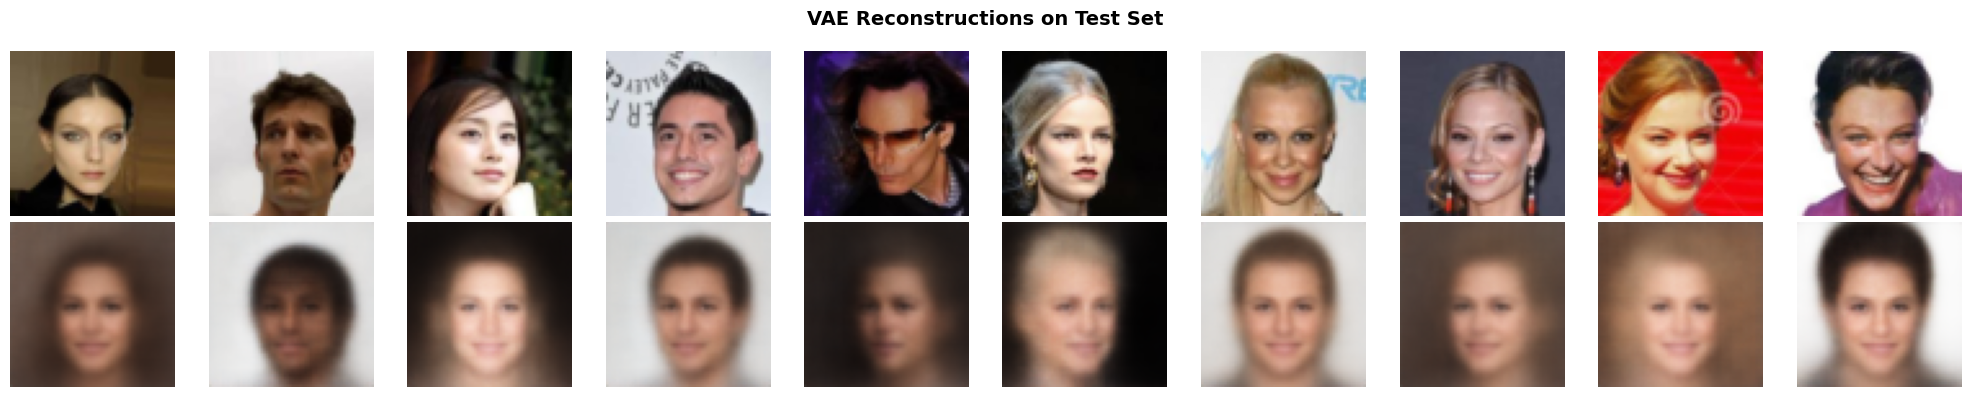

✅ Reconstructions displayed above

Generating Random Samples from Latent Space


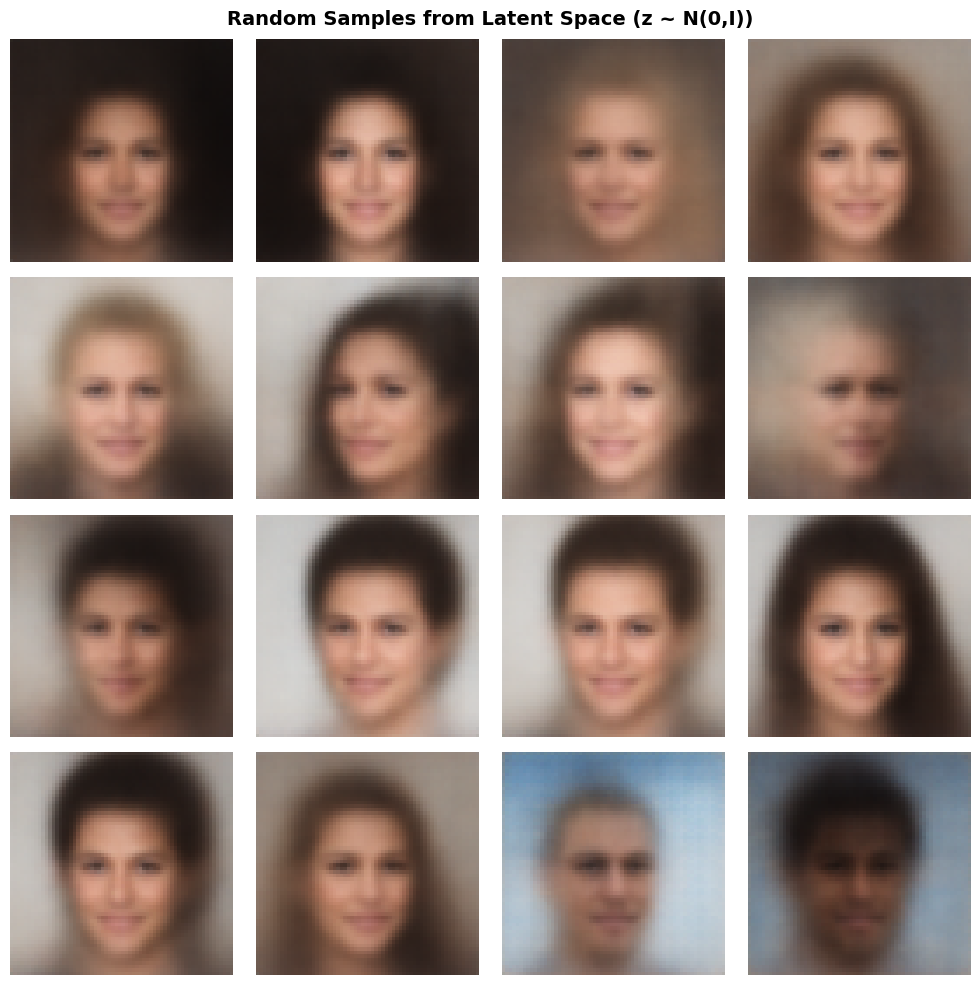

✅ Random samples displayed above

Generating Latent Space Interpolations


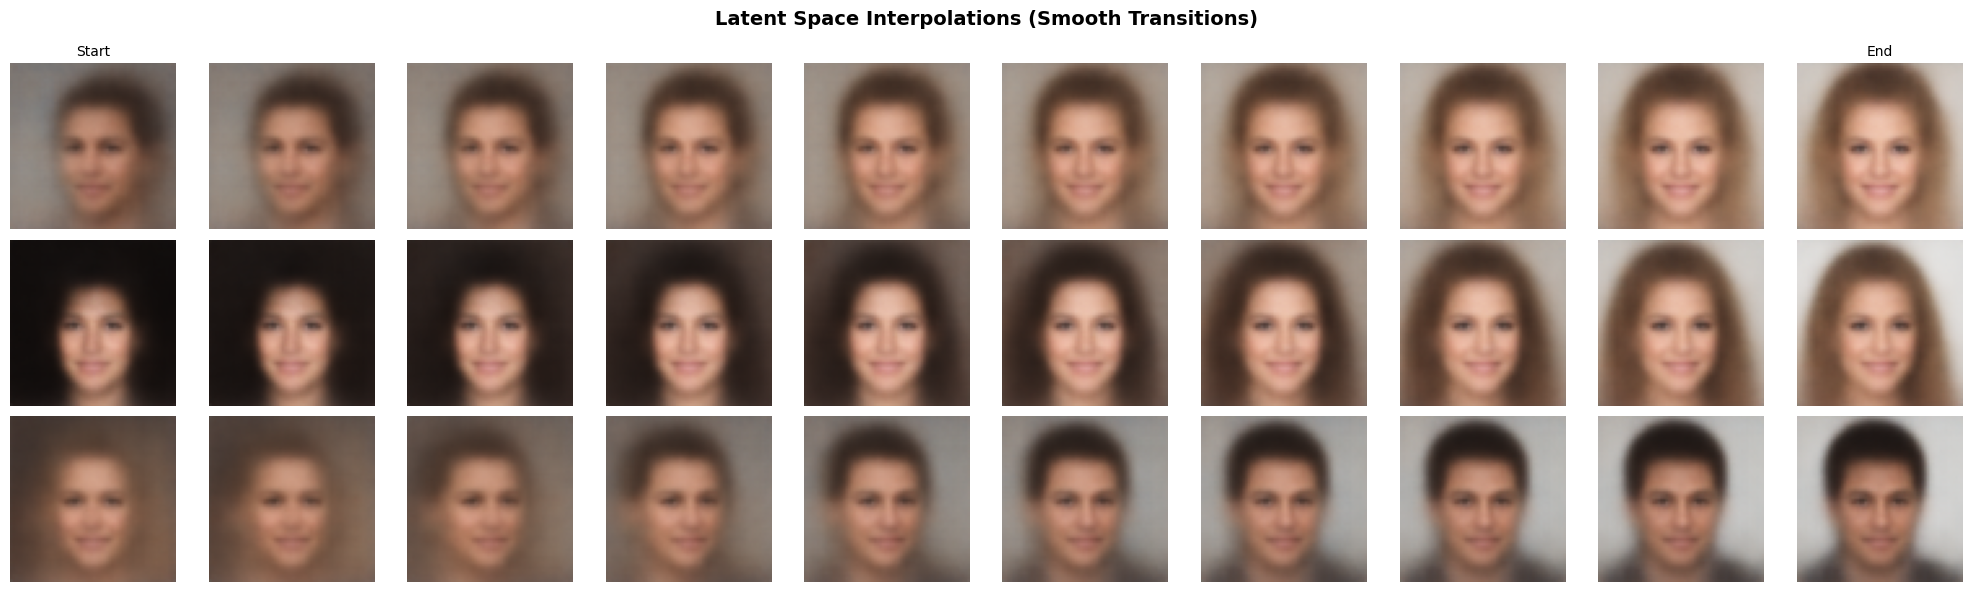

✅ Interpolations displayed above

Generating Latent Dimension Traversals


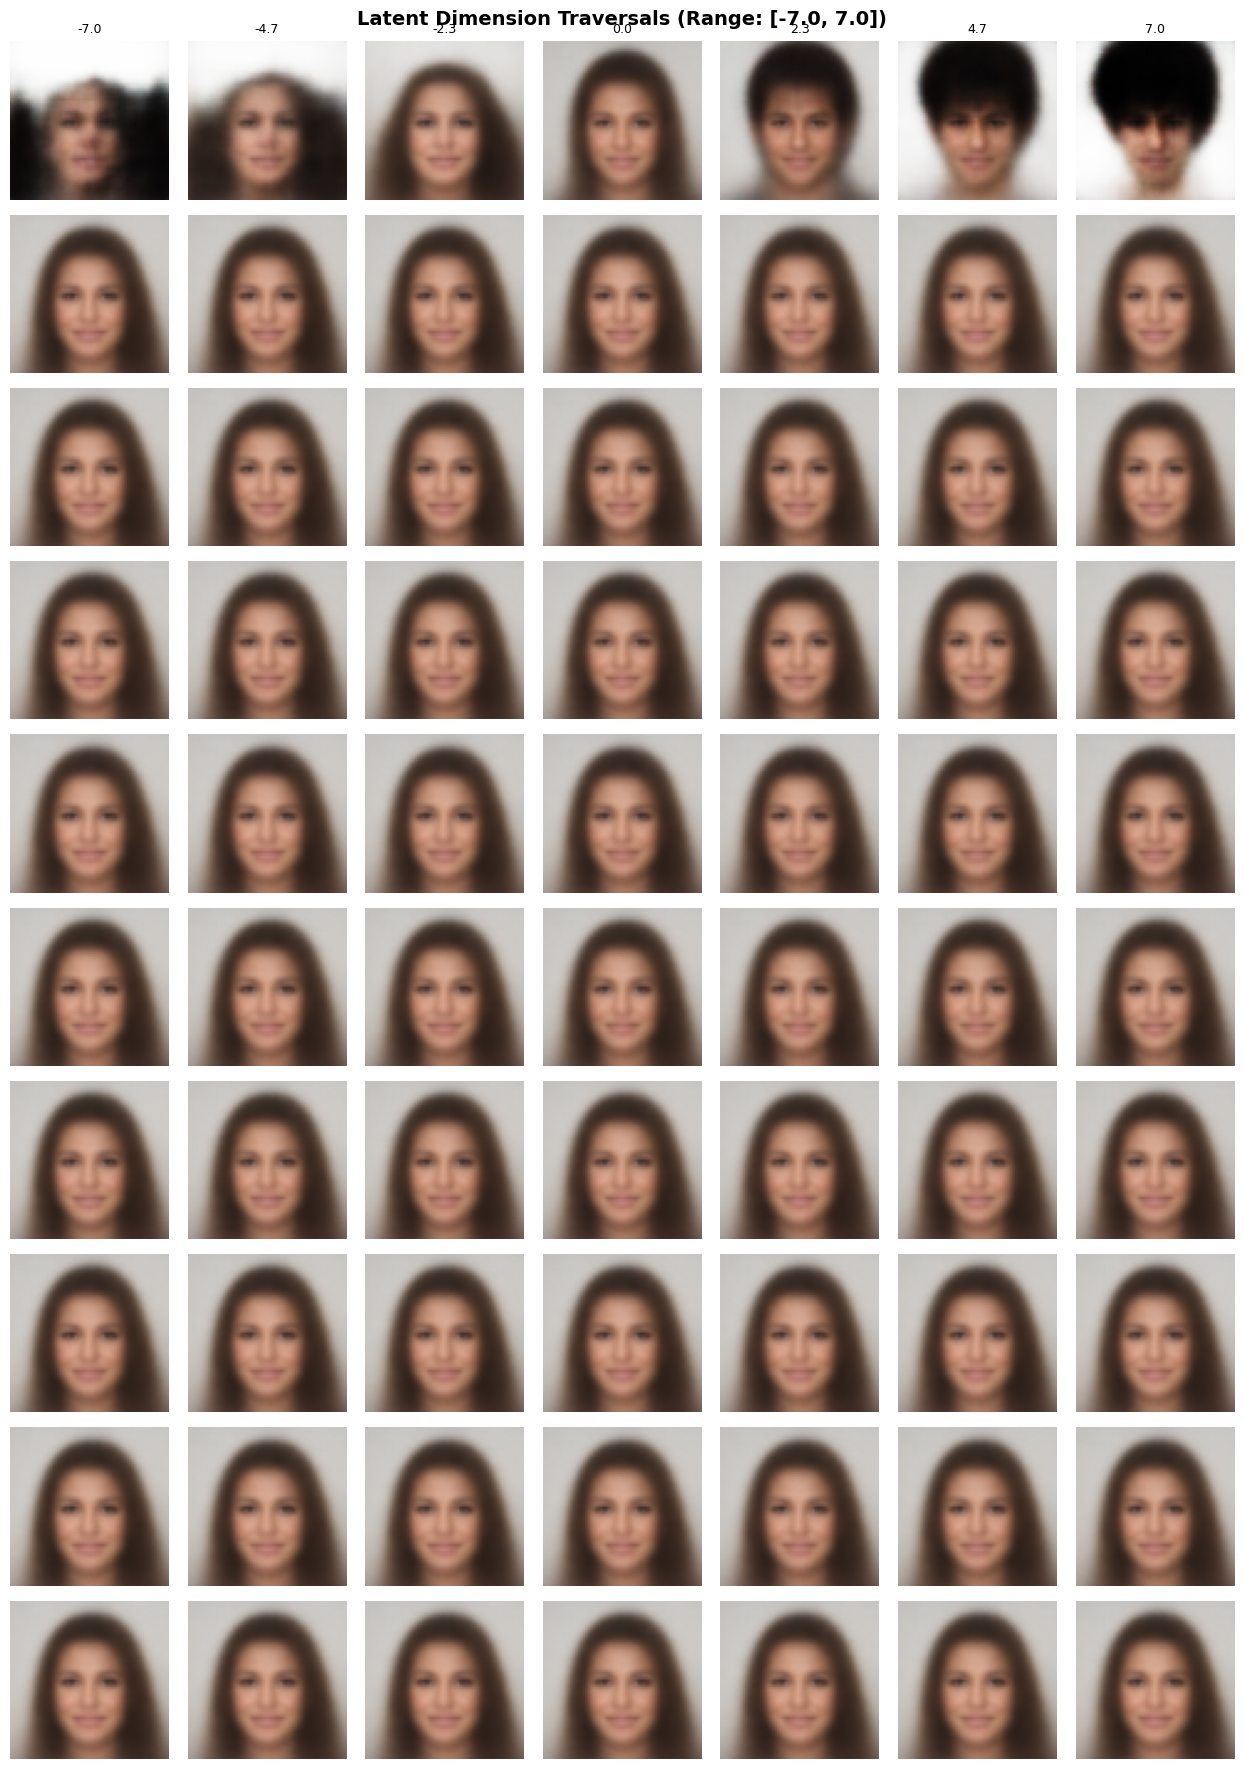

✅ Latent traversals displayed above
   Each row shows how varying a single latent dimension affects the generated face

Computing Reconstruction Quality Metrics
✅ Reconstruction Quality Metrics (on 10 test batches):
   Mean Squared Error (MSE): 0.025551
   Mean Absolute Error (MAE): 0.118166

Testing Complete - Summary

📊 Model Information:
   Latent Dimension: 128
   Image Size: 64×64
   Training Epochs: 49
   Beta (β): 10.0

📈 Performance:
   Best Validation Loss: 6913.3432
   Test MSE: 0.025551
   Test MAE: 0.118166

✅ Generated Visualizations:
   1. ✓ Original vs. Reconstructed (10 samples)
   2. ✓ Random Samples from Latent Space (16 samples)
   3. ✓ Latent Space Interpolations (3 pairs)
   4. ✓ Latent Dimension Traversals (10 dimensions)

💾 Model checkpoint location:
   ./outputs_beta_10/vae_baseline_latent128_20260105_210833/checkpoints/best_model.pth

🎉 Phase 1 Task 1 & 2 Complete!

📝 Next Steps for Portfolio 3:
   - Task 3: Train β-VAE variants (β=4, β=10)
   - Part 2: Answer 

In [ ]:
"""
SECOND CELL - VAE Testing and Visualization
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import glob

# Reuse the VAE and Dataset classes from first cell (already defined)
# No need to redefine them

print("=" * 60)
print("VAE Model Testing and Visualization")
print("=" * 60)

# ============================================================================
# Configuration
# ============================================================================

output_dirs = glob.glob('./outputs_beta_10/vae_baseline_latent128_*')
if not output_dirs:
    raise FileNotFoundError("No output directories found! Make sure training completed.")

output_dir = sorted(output_dirs)[-1]  # Get most recent
checkpoint_dir = os.path.join(output_dir, 'checkpoints')
print(f"\nUsing output directory: {output_dir}")

# Check which checkpoint to use
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')

if os.path.exists(best_model_path):
    checkpoint_path = best_model_path
    print(f"Loading BEST model: {checkpoint_path}")
elif os.path.exists(final_model_path):
    checkpoint_path = final_model_path
    print(f"Loading FINAL model: {checkpoint_path}")
else:
    # Find latest checkpoint
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
    if checkpoints:
        checkpoint_path = sorted(checkpoints)[-1]
        print(f"Loading latest checkpoint: {checkpoint_path}")
    else:
        raise FileNotFoundError("No checkpoints found!")

# ============================================================================
# Load Model
# ============================================================================

print("\n" + "=" * 60)
print("Loading Trained Model")
print("=" * 60)

checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['config']

# Create model
model = VAE(latent_dim=config['latent_dim']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded successfully!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Latent dimension: {config['latent_dim']}")
if 'val_loss' in checkpoint:
    print(f"   Validation loss: {checkpoint['val_loss']:.4f}")

# ============================================================================
# Load Test Dataset
# ============================================================================

print("\n" + "=" * 60)
print("Loading Test Dataset")
print("=" * 60)

celeba_root = './CelebA'
partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')

transform = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.CenterCrop(config['img_size']),
    transforms.ToTensor(),
])

test_dataset = CelebADataset(
    root_dir=celeba_root,
    partition_file=partition_file,
    split='test',
    transform=transform,
    subset_size=2000  # Use 2000 test images
)

# CRITICAL FIX: Set num_workers=0 for Jupyter notebooks
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0  # CHANGED FROM 2 to 0 - required for notebooks!
)

print(f"✅ Test dataset loaded: {len(test_dataset)} images")

# ============================================================================
# Visualization 1: Reconstructions
# ============================================================================

print("\n" + "=" * 60)
print("Generating Reconstructions")
print("=" * 60)

def visualize_reconstructions(model, dataset, num_samples=10):
    """Visualize original and reconstructed images"""
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img = dataset[idx].unsqueeze(0).to(device)
            recon, _, _ = model(img)
            
            # Original
            img_np = img[0].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
            
            # Reconstruction
            recon_np = recon[0].cpu().permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon_np)
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')
    
    plt.suptitle('VAE Reconstructions on Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig1 = visualize_reconstructions(model, test_dataset, num_samples=10)
print("✅ Reconstructions displayed above")

# ============================================================================
# Visualization 2: Random Samples from Latent Space
# ============================================================================

print("\n" + "=" * 60)
print("Generating Random Samples from Latent Space")
print("=" * 60)

def generate_random_samples(model, num_samples=16):
    """Generate random samples from the latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()
    
    # Plot
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2.5, grid_size * 2.5))
    axes = axes.flatten()
    
    for i in range(num_samples):
        sample_np = samples[i].permute(1, 2, 0).numpy()
        axes[i].imshow(sample_np)
        axes[i].axis('off')
    
    plt.suptitle('Random Samples from Latent Space (z ~ N(0,I))', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = generate_random_samples(model, num_samples=16)
print("✅ Random samples displayed above")

# ============================================================================
# Visualization 3: Latent Space Interpolation
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Space Interpolations")
print("=" * 60)

def interpolate_latent(model, dataset, num_pairs=3, num_steps=10):
    """Interpolate between pairs of images in latent space"""
    model.eval()
    
    fig, axes = plt.subplots(num_pairs, num_steps, figsize=(num_steps * 2, num_pairs * 2))
    
    with torch.no_grad():
        for pair_idx in range(num_pairs):
            idx1, idx2 = np.random.choice(len(dataset), 2, replace=False)
            img1 = dataset[idx1].unsqueeze(0).to(device)
            img2 = dataset[idx2].unsqueeze(0).to(device)
            
            # Encode to latent space
            mu1, _ = model.encode(img1)
            mu2, _ = model.encode(img2)
            
            # Interpolate
            alphas = np.linspace(0, 1, num_steps)
            
            for step_idx, alpha in enumerate(alphas):
                # Linear interpolation in latent space
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                
                # Decode
                img_interp = model.decode(z_interp)
                
                # Display
                img_np = img_interp[0].cpu().permute(1, 2, 0).numpy()
                
                if num_pairs == 1:
                    axes[step_idx].imshow(img_np)
                    axes[step_idx].axis('off')
                    if step_idx == 0:
                        axes[step_idx].set_title('Start', fontsize=10)
                    elif step_idx == num_steps - 1:
                        axes[step_idx].set_title('End', fontsize=10)
                else:
                    axes[pair_idx, step_idx].imshow(img_np)
                    axes[pair_idx, step_idx].axis('off')
                    
                    if step_idx == 0:
                        axes[pair_idx, step_idx].set_ylabel(f'Pair {pair_idx+1}', fontsize=10, fontweight='bold')
                    if pair_idx == 0:
                        if step_idx == 0:
                            axes[pair_idx, step_idx].set_title('Start', fontsize=10)
                        elif step_idx == num_steps - 1:
                            axes[pair_idx, step_idx].set_title('End', fontsize=10)
    
    plt.suptitle('Latent Space Interpolations (Smooth Transitions)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig3 = interpolate_latent(model, test_dataset, num_pairs=3, num_steps=10)
print("✅ Interpolations displayed above")

# ============================================================================
# Visualization 4: Latent Dimension Traversals
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Dimension Traversals")
print("=" * 60)

def traverse_latent_dims(model, dataset, num_dims=10, num_steps=7, traversal_range=3.0):
    """
    Traverse individual latent dimensions to see their effect
    Shows what each dimension controls in the generated images
    """
    model.eval()
    
    with torch.no_grad():
        # Get a random image and encode it
        idx = np.random.choice(len(dataset))
        img = dataset[idx].unsqueeze(0).to(device)
        mu, _ = model.encode(img)
        
        # Select random dimensions to traverse
        dims_to_traverse = np.random.choice(model.latent_dim, num_dims, replace=False)
        
        fig, axes = plt.subplots(num_dims, num_steps, figsize=(num_steps * 1.8, num_dims * 1.8))
        
        traversal_values = np.linspace(-traversal_range, traversal_range, num_steps)
        
        for dim_idx, dim in enumerate(dims_to_traverse):
            for step_idx, value in enumerate(traversal_values):
                # Copy the latent vector and modify one dimension
                z_modified = mu.clone()
                z_modified[0, dim] = value
                
                # Decode
                img_generated = model.decode(z_modified)
                img_np = img_generated[0].cpu().permute(1, 2, 0).numpy()
                
                # Display
                axes[dim_idx, step_idx].imshow(img_np)
                axes[dim_idx, step_idx].axis('off')
                
                if step_idx == 0:
                    axes[dim_idx, step_idx].set_ylabel(f'Dim {dim}', fontsize=9, fontweight='bold')
                
                if dim_idx == 0:
                    axes[dim_idx, step_idx].set_title(f'{value:.1f}', fontsize=9)
        
        plt.suptitle(f'Latent Dimension Traversals (Range: [{-traversal_range:.1f}, {traversal_range:.1f}])', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return fig

fig4 = traverse_latent_dims(model, test_dataset, num_dims=10, num_steps=7, traversal_range=7.0) #TOBECHANGEDANDCHECKED - abcd
print("✅ Latent traversals displayed above")
print("   Each row shows how varying a single latent dimension affects the generated face")

# ============================================================================
# Compute Reconstruction Quality Metrics
# ============================================================================

print("\n" + "=" * 60)
print("Computing Reconstruction Quality Metrics")
print("=" * 60)

def compute_reconstruction_metrics(model, test_loader, num_batches=10):
    """Compute average reconstruction metrics on test set"""
    model.eval()
    
    mse_total = 0
    mae_total = 0
    n_samples = 0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            if batch_idx >= num_batches:
                break
            
            data = data.to(device)
            recon, _, _ = model(data)
            
            # MSE (Mean Squared Error)
            mse = torch.mean((recon - data) ** 2, dim=[1, 2, 3])
            mse_total += mse.sum().item()
            
            # MAE (Mean Absolute Error)
            mae = torch.mean(torch.abs(recon - data), dim=[1, 2, 3])
            mae_total += mae.sum().item()
            
            n_samples += data.size(0)
    
    avg_mse = mse_total / n_samples
    avg_mae = mae_total / n_samples
    
    return avg_mse, avg_mae

avg_mse, avg_mae = compute_reconstruction_metrics(model, test_loader, num_batches=10)

print(f"✅ Reconstruction Quality Metrics (on {10} test batches):")
print(f"   Mean Squared Error (MSE): {avg_mse:.6f}")
print(f"   Mean Absolute Error (MAE): {avg_mae:.6f}")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 60)
print("Testing Complete - Summary")
print("=" * 60)

print(f"\n📊 Model Information:")
print(f"   Latent Dimension: {config['latent_dim']}")
print(f"   Image Size: {config['img_size']}×{config['img_size']}")
print(f"   Training Epochs: {checkpoint['epoch']}")
print(f"   Beta (β): {config['beta']}")

print(f"\n📈 Performance:")
if 'val_loss' in checkpoint:
    print(f"   Best Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Test MSE: {avg_mse:.6f}")
print(f"   Test MAE: {avg_mae:.6f}")

print(f"\n✅ Generated Visualizations:")
print(f"   1. ✓ Original vs. Reconstructed (10 samples)")
print(f"   2. ✓ Random Samples from Latent Space (16 samples)")
print(f"   3. ✓ Latent Space Interpolations (3 pairs)")
print(f"   4. ✓ Latent Dimension Traversals (10 dimensions)")

print(f"\n💾 Model checkpoint location:")
print(f"   {checkpoint_path}")

print("\n" + "=" * 60)